In [183]:
from pydantic import BaseModel, Field
from typing import List
import numpy as np
import pandas as pd
from collections import defaultdict
import os

In [184]:
# parse tsplib file and generate a list of coordinates
def parse_tsplib_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if line.startswith('NODE_COORD_SECTION'):
                break
        coords = []
        for line in lines[i+1:]:
            if line.startswith('EOF'):
                break
            parts = line.split()
            coords.append((float(parts[1]), float(parts[2])))
        return coords

    data = parse_tsplib_file('./tsplib/berlin52.tsp')

In [185]:
# override data with simple example 5x5 grid from -2 to 2
data = [(x, y) for x in np.linspace(-2, 2, 5) for y in np.linspace(-2, 2, 5)]

In [186]:
data

[(-2.0, -2.0),
 (-2.0, -1.0),
 (-2.0, 0.0),
 (-2.0, 1.0),
 (-2.0, 2.0),
 (-1.0, -2.0),
 (-1.0, -1.0),
 (-1.0, 0.0),
 (-1.0, 1.0),
 (-1.0, 2.0),
 (0.0, -2.0),
 (0.0, -1.0),
 (0.0, 0.0),
 (0.0, 1.0),
 (0.0, 2.0),
 (1.0, -2.0),
 (1.0, -1.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (1.0, 2.0),
 (2.0, -2.0),
 (2.0, -1.0),
 (2.0, 0.0),
 (2.0, 1.0),
 (2.0, 2.0)]

In [187]:
import math


def calculate_distance(point1, point2):
    distance = math.sqrt((point1[0] - point2[0]) **
                         2 + (point1[1] - point2[1])**2)
    return distance

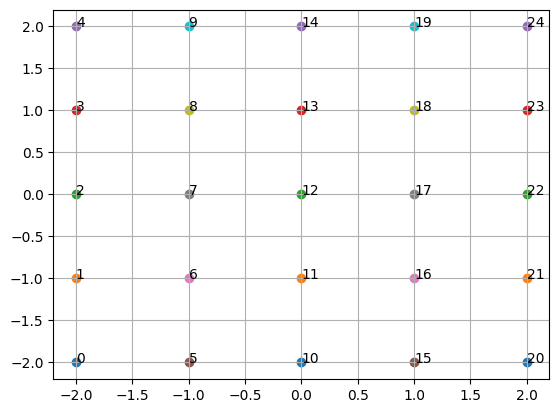

In [188]:
# show the data
import matplotlib.pyplot as plt

# label each point by its index
for i, point in enumerate(data):
    plt.scatter(point[0], point[1])
    plt.text(point[0], point[1], str(i))

plt.grid()
plt.show()

In [189]:
def calculate_distance_matrix(nodes: List[tuple]):
    """
    Calculates the Euclidean distance matrix between a set of nodes.

    Args:
                    nodes: A list of Node objects.

    Returns:
                    A NumPy array representing the distance matrix.
    """

    num_nodes = len(nodes)
    distance_matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(num_nodes):
            distance_matrix[i][j] = np.sqrt(
                (nodes[i][0] - nodes[j][0])**2 + (nodes[i][1] - nodes[j][1])**2)

    return distance_matrix

In [190]:
def allocate_nodes_nearest_neighbor(nodes: List[tuple], hub_indices: List[int], distance_matrix: np.ndarray) -> dict:
    """
    Assigns non-hub nodes to their nearest hub using a nearest neighbor approach (hubs represented by indices).

    Args:
                    nodes: A list of all Node objects.
                    hub_indices:  A list of indices corresponding to hub nodes.
                    distance_matrix: A NumPy array representing distances between each pair of nodes.

    Returns:
                    A dictionary of assignments: {hub_index: [list of assigned non-hub nodes]}
    """
    assignments = defaultdict(list)
    for node_index, node in enumerate(nodes):
        if node_index in hub_indices:
            continue  # Skip if the node itself is a hub

        distances_to_hubs = [distance_matrix[node_index]
                             [hub_index] for hub_index in hub_indices]
        nearest_hub_index = hub_indices[np.argmin(distances_to_hubs)]
        assignments[nearest_hub_index].append(node_index)

    return assignments

In [191]:
def solve_ring_tsp_nearest_neighbor(distance_matrix: np.ndarray, hub_indices: List[int]) -> List[int]:
    """
    Solves the TSP to form an approximate ring connecting the selected hubs using the nearest neighbor algorithm.

    Args:
        distance_matrix: A NumPy array representing distances between each pair of nodes.
        hub_indices: A list of indices corresponding to the selected hub nodes.

    Returns:
        A list of hub indices (in the original node list) in the order they should be visited to form the approximate ring.
    """

    # Start with the first hub
    current_hub = hub_indices[0]

    # Initialize the list of hubs in the order they will be visited
    ordered_hubs = [current_hub]
    remaining_hubs = hub_indices[1:]

    while remaining_hubs:
        next_hub = remaining_hubs[np.argmin(
            distance_matrix[current_hub, remaining_hubs])]
        ordered_hubs.append(next_hub)
        remaining_hubs.remove(next_hub)
        current_hub = next_hub

    return ordered_hubs

In [192]:
# define the cost of edges between hubs and non-hubs

HUB_EDGE_COST = 3
NON_HUB_EDGE_COST = 1

In [193]:
# Calculate the distance matrix
distance_matrix = calculate_distance_matrix(data)

In [ ]:
# define fitness function
def fitness_func(data: List[tuple], mask: List[int], distance_matrix: np.ndarray):
    """
    Calculates the fitness of a given mask, which represents a potential solution to the problem.

    Args:
                    mask: A list of integers representing the order in which the nodes will be visited.

    Returns:
                    The fitness of the mask.
    """
    # Create a list of hub indices and non-hub indices based on the mask
    hub_indices = [i for i, x in enumerate(mask) if x == 1]
    non_hub_indices = [i for i, x in enumerate(mask) if x == 0]

    # Allocate non-hub nodes to the nearest hub
    assignments = allocate_nodes_nearest_neighbor(
        data, hub_indices, distance_matrix)

    # Solve the TSP to form an approximate ring connecting the selected hubs
    ordered_hubs = solve_ring_tsp_nearest_neighbor(
        distance_matrix, hub_indices)

    # Calculate the total cost of the solution
    total_cost = 0
    for i, hub_index in enumerate(ordered_hubs):
        next_hub_index = ordered_hubs[(i + 1) % len(ordered_hubs)]
        total_cost += distance_matrix[hub_index, next_hub_index]

    for hub_index, assigned_nodes in assignments.items():
        for node_index in assigned_nodes:
            total_cost += HUB_EDGE_COST * \
                distance_matrix[hub_index, node_index]

    for node_index in non_hub_indices:
        total_cost += NON_HUB_EDGE_COST * \
            distance_matrix[node_index, ordered_hubs[0]]

    return total_cost